In [4]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt
from sklearn.metrics import plot_confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics as mt
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
from collections import Counter
from imblearn.over_sampling import SMOTE
import seaborn as sns
from sklearn.naive_bayes import ComplementNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

In [5]:
url = "https://raw.githubusercontent.com/nedeinlein/Machine_Learning_I/main/runs_clean.csv"
runs_df = pd.read_csv(url, index_col=False)

runs_df.head()

,Unnamed: 0,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country,horse_type,...,behind_sec2,behind_sec3,time1,time2,time3,finish_time,win_odds,place_odds,trainer_id,jockey_id
0,0,0,1,3917,10,0.0,8.00,3,AUS,Gelding,...,2.00,1.50,13.85,21.59,23.86,83.92,9.7,3.7,118,2
1,1,0,2,2157,8,0.0,5.75,3,NZ,Gelding,...,9.00,5.00,14.57,21.99,23.30,83.56,16.0,4.9,164,57
2,2,0,3,858,7,0.0,4.75,3,NZ,Gelding,...,1.00,0.75,13.69,21.59,23.90,83.40,3.5,1.5,137,18
3,3,0,4,1853,9,0.0,6.25,3,SAF,Gelding,...,5.00,3.50,14.09,21.83,23.70,83.62,39.0,11.0,80,59
4,4,0,5,2796,6,0.0,3.75,3,GB,Gelding,...,8.75,4.25,14.77,21.75,23.22,83.24,50.0,14.0,9,154


In [6]:
# Use one hot encoding on non-numerical features
## (Then remove them from the drop code chunk below)
# perform one-hot encoding of the categorical data "embarked"
tmp_df = pd.get_dummies(runs_df.horse_country,prefix='horse_country')
runs_df_onehot = pd.concat((runs_df,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(runs_df.horse_type,prefix='horse_type')
runs_df_onehot = pd.concat((runs_df_onehot,tmp_df),axis=1) # add back into the dataframe

runs_df = runs_df_onehot.reset_index(drop=True)

In [7]:
# Add a Show result feature
runs_df['show'] = np.where(runs_df['result'] <= 3, 1, 0)
runs_df.head(10)

,Unnamed: 0,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country,horse_type,...,horse_type_Brown,horse_type_Colt,horse_type_Filly,horse_type_Gelding,horse_type_Grey,horse_type_Horse,horse_type_Mare,horse_type_Rig,horse_type_Roan,show
0,0,0,1,3917,10,0.0,8.00,3,AUS,Gelding,...,0,0,0,1,0,0,0,0,0,0
1,1,0,2,2157,8,0.0,5.75,3,NZ,Gelding,...,0,0,0,1,0,0,0,0,0,0
2,2,0,3,858,7,0.0,4.75,3,NZ,Gelding,...,0,0,0,1,0,0,0,0,0,0
3,3,0,4,1853,9,0.0,6.25,3,SAF,Gelding,...,0,0,0,1,0,0,0,0,0,0
4,4,0,5,2796,6,0.0,3.75,3,GB,Gelding,...,0,0,0,1,0,0,0,0,0,0
5,5,0,6,3296,3,0.0,1.25,3,NZ,Gelding,...,0,0,0,1,0,0,0,0,0,1
6,6,0,7,911,12,0.0,9.50,3,NZ,Gelding,...,0,0,0,1,0,0,0,0,0,0
7,7,0,8,2170,1,1.0,0.00,3,AUS,Gelding,...,0,0,0,1,0,0,0,0,0,1
8,8,0,9,1730,13,0.0,9.75,3,NZ,Gelding,...,0,0,0,1,0,0,0,0,0,0
9,9,0,10,2998,14,0.0,999.00,3,AUS,Mare,...,0,0,0,0,0,0,1,0,0,0


In [8]:
runs_data = runs_df.drop(['Unnamed: 0','race_id','horse_id','result','won','lengths_behind','horse_country','horse_type','horse_gear','position_sec1','position_sec2','position_sec3','behind_sec1','behind_sec2','behind_sec3','time1','time2','time3','finish_time','trainer_id','jockey_id','show'], axis=1)
runs_target = runs_df['won']
runs_target2 = runs_df['show']
runs_data.head()

,horse_no,horse_age,horse_rating,declared_weight,actual_weight,draw,win_odds,place_odds,horse_country_ARG,horse_country_AUS,...,horse_country_ZIM,horse_type_Brown,horse_type_Colt,horse_type_Filly,horse_type_Gelding,horse_type_Grey,horse_type_Horse,horse_type_Mare,horse_type_Rig,horse_type_Roan
0,1,3,60,1020.0,133,7,9.7,3.7,0,1,...,0,0,0,0,1,0,0,0,0,0
1,2,3,60,980.0,133,12,16.0,4.9,0,0,...,0,0,0,0,1,0,0,0,0,0
2,3,3,60,1082.0,132,8,3.5,1.5,0,0,...,0,0,0,0,1,0,0,0,0,0
3,4,3,60,1118.0,127,13,39.0,11.0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,5,3,60,972.0,131,14,50.0,14.0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [9]:
runs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79423 entries, 0 to 79422
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   horse_no            79423 non-null  int64  
 1   horse_age           79423 non-null  int64  
 2   horse_rating        79423 non-null  int64  
 3   declared_weight     79423 non-null  float64
 4   actual_weight       79423 non-null  int64  
 5   draw                79423 non-null  int64  
 6   win_odds            79423 non-null  float64
 7   place_odds          79423 non-null  float64
 8   horse_country_ARG   79423 non-null  uint8  
 9   horse_country_AUS   79423 non-null  uint8  
 10  horse_country_BRZ   79423 non-null  uint8  
 11  horse_country_CAN   79423 non-null  uint8  
 12  horse_country_FR    79423 non-null  uint8  
 13  horse_country_GB    79423 non-null  uint8  
 14  horse_country_GER   79423 non-null  uint8  
 15  horse_country_GR    79423 non-null  uint8  
 16  hors

In [10]:
cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, train_size=0.8, random_state = 0)

# fill in the training and testing data and save as separate variables
for trainidx, testidx in cv.split(runs_data,runs_target):
    # note that these are sparse matrices
    X_train,X_test = runs_data.iloc[trainidx], runs_data.iloc[testidx] 
    Y_train, Y_test = runs_target.iloc[trainidx], runs_target.iloc[testidx]

In [11]:
# CV for the 'show' target
cv_Show = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, train_size=0.8, random_state = 0)

# fill in the training and testing data and save as separate variables
for trainidx_Show, testidx_Show in cv.split(runs_data,runs_target2):
    # note that these are sparse matrices
    X_train_Show,X_test_Show = runs_data.iloc[trainidx_Show], runs_data.iloc[testidx_Show] 
    Y_train_Show, Y_test_Show = runs_target.iloc[trainidx_Show], runs_target.iloc[testidx_Show]

In [12]:
scl_obj = StandardScaler()
X_train = scl_obj.fit_transform(X_train, y = None)
X_test = scl_obj.fit_transform(X_test, y = None)

scl_obj = StandardScaler()
X_train_Show = scl_obj.fit_transform(X_train_Show, y = None)
X_test_Show = scl_obj.fit_transform(X_test_Show, y = None)

## **Naive Bayes Classifier**

Naive Bayes is a commonly used classification algorithm and can help us in predicting whether a horse will win or not win a race. Two versions of the Naive Bayes classifier were imported and used which are Gaussian Naive Bayes and Complement Naive Bayes. 

Gaussian Naive Bayes assumes that the data is drawn from a simple Gaussian distribution, and the var_smoothing parameter can be manually adjusted to smooth out the variance. Complement Naive Bayes is suited better for imbalanced datasets such as the horse racing dataset, with the alpha parameter being a manually adjusted additive smoothing parameter. 

Both the Gaussian and Complement Naive Bayes classifiers were used on our two target response variables ('won' and 'show').

#### Gaussian Naive Bayes on the 'won' target response variable:

In [1]:
var = [.25,.5,1,2,3,4,5,6,7,8,9,10,15,20]
for x in var:
    # define the pipeline
    steps = list()
    steps.append(('scaler', StandardScaler()))
    steps.append(('model', GaussianNB(var_smoothing=x)))
    pipeline = Pipeline(steps=steps)

    # define the evaluation procedure
    cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, train_size=0.8, random_state = 0)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, runs_data, runs_target, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When x =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

NameError: name 'StandardScaler' is not defined

#### Complement Naive Bayes on the 'Won' target response variable:

In [14]:
var2 = [.05,.25,1,3,5,6]
for x in var2:
    # define the pipeline
    steps = list()
    steps.append(('scaler', MinMaxScaler()))
    steps.append(('model', ComplementNB(alpha = x)))
    pipeline = Pipeline(steps=steps)

    # define the evaluation procedure
    cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, train_size=0.8, random_state = 0)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, runs_data, runs_target, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When x =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

When x = 0.05
   Mean Precision:  0.13102338394721938
   Mean AUC:  0.746677728799247
   Mean Accuracy:  0.5421466792571608
   Mean Time per Split:  0.1073300838470459
 
When x = 0.25
   Mean Precision:  0.13109039000011966
   Mean AUC:  0.746798216845774
   Mean Accuracy:  0.5424425558703179
   Mean Time per Split:  0.07463955879211426
 
When x = 1
   Mean Precision:  0.13144789182233368
   Mean AUC:  0.7473594417308272
   Mean Accuracy:  0.5436701290525653
   Mean Time per Split:  0.09285187721252441
 
When x = 3
   Mean Precision:  0.1322228259228747
   Mean AUC:  0.7480043669654013
   Mean Accuracy:  0.5469499527856468
   Mean Time per Split:  0.08076250553131104
 
When x = 5
   Mean Precision:  0.13288069143564354
   Mean AUC:  0.7480641536979006
   Mean Accuracy:  0.5504060434372049
   Mean Time per Split:  0.0731919527053833
 
When x = 6
   Mean Precision:  0.13324284248439383
   Mean AUC:  0.7480613938136415
   Mean Accuracy:  0.5524457034938621
   Mean Time per Split:  0.07227

#### Gaussian Naive Bayes on the 'show' target response variable:

In [15]:
var3 = [.25,.5,.75,.95,1,1.2,1.4,1.6,2]
for x in var3:
    # define the pipeline
    steps = list()
    steps.append(('scaler', StandardScaler()))
    steps.append(('model', GaussianNB(var_smoothing=x)))
    pipeline = Pipeline(steps=steps)

    # define the evaluation procedure
    cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, train_size=0.8, random_state = 0)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, runs_data, runs_target2, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When x =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

When x = 0.25
   Mean Precision:  0.28051887901406747
   Mean AUC:  0.7047869038500877
   Mean Accuracy:  0.40098205854579794
   Mean Time per Split:  0.11887762546539307
 
When x = 0.5
   Mean Precision:  0.27802573761487837
   Mean AUC:  0.7065664399389135
   Mean Accuracy:  0.3925023607176582
   Mean Time per Split:  0.1134246826171875
 
When x = 0.75
   Mean Precision:  0.2771895067236395
   Mean AUC:  0.7078383347523913
   Mean Accuracy:  0.3893862134088763
   Mean Time per Split:  0.12007863521575929
 
When x = 0.95
   Mean Precision:  0.27722924657979336
   Mean AUC:  0.7086980347133042
   Mean Accuracy:  0.38919735599622285
   Mean Time per Split:  0.11339418888092041
 
When x = 1
   Mean Precision:  0.27729988516412574
   Mean AUC:  0.7088968244905948
   Mean Accuracy:  0.3893862134088763
   Mean Time per Split:  0.11846880912780762
 
When x = 1.2
   Mean Precision:  0.2778487207681709
   Mean AUC:  0.7096466191486451
   Mean Accuracy:  0.39102927289896133
   Mean Time per Spl

#### Complement Naive Bayes on the 'show' target response variable:

In [16]:
var4 = [.001,1,5,20,30,50]
for x in var4:
    # define the pipeline
    steps = list()
    steps.append(('scaler', MinMaxScaler()))
    steps.append(('model', ComplementNB(alpha = x)))
    pipeline = Pipeline(steps=steps)

    # define the evaluation procedure
    cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, train_size=0.8, random_state = 0)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, runs_data, runs_target2, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When x =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

When x = 0.001
   Mean Precision:  0.34871056495033725
   Mean AUC:  0.7419934128075327
   Mean Accuracy:  0.5864463330185711
   Mean Time per Split:  0.06559746265411377
 
When x = 1
   Mean Precision:  0.34888837823463803
   Mean AUC:  0.742215117807883
   Mean Accuracy:  0.5867170286433742
   Mean Time per Split:  0.08674402236938476
 
When x = 5
   Mean Precision:  0.34963042114635734
   Mean AUC:  0.7427586265778003
   Mean Accuracy:  0.5877368586717029
   Mean Time per Split:  0.07158479690551758
 
When x = 20
   Mean Precision:  0.352164140948355
   Mean AUC:  0.7433323022786439
   Mean Accuracy:  0.5917406358199558
   Mean Time per Split:  0.07496123313903809
 
When x = 30
   Mean Precision:  0.35407885653796833
   Mean AUC:  0.7429834664536602
   Mean Accuracy:  0.5954674220963173
   Mean Time per Split:  0.0696603775024414
 
When x = 50
   Mean Precision:  0.3583065324313309
   Mean AUC:  0.7418565558306772
   Mean Accuracy:  0.6043500157381178
   Mean Time per Split:  0.0669

What was interesting after running both Naive Bayes classifiers on our two target response variables is that the Gaussian Naive Bayes classifier provided better results on the 'won' target whereas the Complement Naive Bayes classifier provided better results on the 'show' target (with precision being the primary metric).

Next we will want to look at the feature importance using the Gaussian Naive Bayes model using the 'Won' feature. From the plot, there a few of the one hot encoded countries that are not significant in our model. However, these features will be left in as they don't overfit our model.

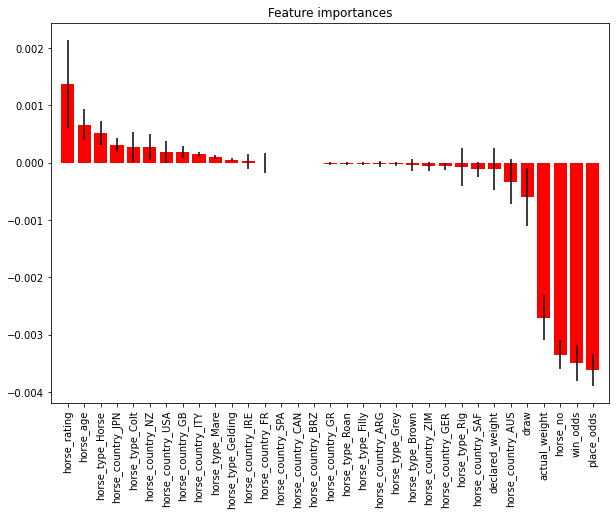

In [19]:

features = list(runs_data.columns.values)

GNBmodel = GaussianNB(var_smoothing=1.2)
GNBmodel.fit(X_train,Y_train)
yhat= GNBmodel.predict(X_test)


from sklearn.inspection import permutation_importance

imps = permutation_importance(GNBmodel, X_test, Y_test)
importances = imps.importances_mean
std = imps.importances_std
indices = np.argsort(importances)[::-1]

# Print the feature ranking

featureorder = []
for f in range(X_test.shape[1]):
    featureorder.append(features[indices[f]])

plt.figure(figsize=(10, 7))
plt.title("Feature importances")
plt.bar(range(X_test.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_test.shape[1]), [features[indices[i]] for i in range(33)],rotation = 90)
plt.xlim([-1, X_test.shape[1]])
plt.show()

## Deployment

The main purpose of the horse racing dataset is to extrapolate any information that would be advantageous to horse betters. As a horse better you want to reduce the number of false positives because otherwise you would be betting on a losing horse. Our model is useful in the sense that we focused on creating a model with the best precision score that we could. That way, the number of false positives are reduced. 

As this dataset is publicly available, we would only deploy this model to other horse betters who are interested in a data-driven advantage. We could deploy this on a publicly available website and constantly update the model as more and more horse racing data is collected. Since our dataset only includes data from two horse tracks in Hong Kong, it would be useful to also collect racing data from other parts of the world. With this data, we can extend our target audience to people globally. 

Once our model is deployed on the web, it would be wise to frequently update it as horse races occur on a daily basis. New competitors are always introduced to the sport, and old horses will eventually retire.